In [26]:
#!/usr/bin/env python3
"""
Offset-free MPC (CT) migrated from `control/offset_free_CT.ipynb`.

- Loads A, B, C, trained Koopman-related modules, scalers, and sim setup
- Builds transformed representation with T_real
- Runs target estimation + MPC closed-loop simulation
- Saves plots under repository `figures/`
- Prints the objective line exactly as in the notebook:
  "Closed-loop objective function value: <value>"

Requires `src/helper` and `src/models` to be importable.
"""

from __future__ import annotations

import sys
from pathlib import Path
from typing import Tuple

import joblib
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

# Optional deps used in helper/model stack
import torch  # noqa: F401
import cvxpy as cp  # noqa: F401

# neuromancer symbols are imported in notebook; here they are required indirectly via helper/models loading
from neuromancer.modules import blocks  # type: ignore
from neuromancer.system import Node, System  # type: ignore
from neuromancer.problem import Problem  # type: ignore
from neuromancer.loss import PenaltyLoss  # type: ignore




In [27]:
# --------------------------- Repository paths ---------------------------------

def get_repo_root() -> Path:
    # In a notebook, __file__ is not defined; use cwd as a fallback
    return Path.cwd().resolve().parent


def get_figures_dir(repo_root: Path) -> Path:
    figures = repo_root / "figures"
    figures.mkdir(parents=True, exist_ok=True)
    return figures


# Ensure `src` is on PYTHONPATH
REPO_ROOT = get_repo_root()
SRC_PATH = REPO_ROOT / 'src'
if SRC_PATH.as_posix() not in sys.path:
    sys.path.append(SRC_PATH.as_posix())

import helper  # type: ignore
import models  # type: ignore


# ------------------------------ IO utilities ----------------------------------

def load_matrices_C_variant(data_dir: Path, matrix_C: bool) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    A = np.load((data_dir / f"A_C_{matrix_C}.npy").as_posix())
    B = np.load((data_dir / f"B_C_{matrix_C}.npy").as_posix())
    C_const = np.load((data_dir / f"C_const_C_{matrix_C}.npy").as_posix())
    return A, B, C_const


def load_scalers(data_dir: Path):
    scaler = joblib.load((data_dir / 'scaler.pkl').as_posix())
    scalerU = joblib.load((data_dir / 'scalerU.pkl').as_posix())
    return scaler, scalerU



# ------------------------------ CT helpers ------------------------------------

def build_encoders_decoders(ny: int, nz: int, nu: int, matrix_C: bool):
    layers = [40, 80, 120]
    layers_dec = [120, 80, 40]

    # output encoder f_y
    f_y = blocks.MLP(
        ny,
        nz,
        bias=True,
        linear_map=torch.nn.Linear,
        nonlin=torch.nn.ReLU,
        hsizes=layers,
    )
    encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
    encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

    # input encoder f_u representing B
    f_u = torch.nn.Linear(nu, nz, bias=False)
    encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

    # decoder
    if not matrix_C:
        f_y_inv = blocks.MLP(
            nz, ny, bias=True, linear_map=torch.nn.Linear, nonlin=torch.nn.ELU, hsizes=layers_dec
        )
    elif matrix_C:
        f_y_inv = torch.nn.Linear(nz, ny, bias=False)
    else:
        raise ValueError('matrix_C must be boolean')
    decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

    # Koopman linear K
    K = torch.nn.Linear(nz, nz, bias=False)
    Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')

    dynamics_model = System([Koopman], name='Koopman', nsteps=1)
    nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]
    loss = PenaltyLoss([], constraints=[])
    problem = Problem(nodes, loss)
    return problem


def get_x_from_y(problem, y: np.ndarray) -> np.ndarray:
    x = problem.nodes[0]({"Y0": torch.from_numpy(y).float()})
    return x["x"].detach().numpy().reshape(1, -1).T


def get_y_from_x(problem, x: np.ndarray) -> np.ndarray:
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"].detach().numpy().reshape(1, -1)





In [28]:
data_dir = REPO_ROOT / 'data'
figures_dir = get_figures_dir(REPO_ROOT)

# Load matrices for matrix_C=False as in notebook
matrix_C = False
A, B, C_const = load_matrices_C_variant(data_dir, matrix_C)

# Extract C_matrix and C_constant from C_const
# C_const has shape (ny, nz+1) where the last column is the constant term
C_matrix = C_const[:, :-1]  # shape: (ny, nz)
C_constant = C_const[:, -1]  # shape: (ny,)

nz, nu = B.shape
ny = C_const.shape[0]

# Disturbance model dimension
F = np.eye(ny)
nd = F.shape[1]

# Block diagonalization
T_real, A_block = helper.ident.real_block_diagonalize(A)

# Transform A to check
A_transformed = inv(T_real) @ A @ T_real
print("Close to block diagonal?", np.allclose(A_block, A_transformed, atol=1e-6))

# Backtransform A_block to verify it equals A
A_backtransformed = T_real @ A_block @ inv(T_real)
print("Backtransformation equals original A?", np.allclose(A, A_backtransformed, atol=1e-6))
# T_real = np.eye(nz)  # Use identity for now, as A is already block diagonal



Close to block diagonal? True
Backtransformation equals original A? True


In [29]:


# Apply transformation as in notebook (Cell 6)
A = inv(T_real) @ A @ T_real
B = inv(T_real) @ B
#C = C @ T_real
# Transform C_matrix (constant term doesn't need transformation)
C_matrix = C_matrix @ T_real
# Note: C_constant does not need transformation as it's independent of z

# Koopman enc/dec + problem and load weights
problem = build_encoders_decoders(ny, nz, nu, matrix_C)
problem.load_state_dict(torch.load((data_dir / f'model_C_{matrix_C}.pth').as_posix()), strict=False)

# Load scalers
scaler, scalerU = load_scalers(data_dir)

# Plant model: use full nonlinear CSTR series with recycle for simulation
CSTR = models.CSTRSeriesRecycle()

# Sim setup
loaded_setup = joblib.load("sim_setup.pkl")


In [30]:
# ------------------------------ CT_const helpers ------------------------------

class KF_const(helper.KF):
    """
    Kalman Filter modified to handle C_matrix and C_constant.
    Measurement equation: y = C_matrix @ z + C_constant + d
    where d is the disturbance part of x.
    """
    def __init__(self, A, B, C_matrix, C_constant, x0, P0, Q, R):
        # Create augmented C_ that includes both C_matrix and constant
        # For the augmented state [z; d], we have: y = C_matrix @ z + C_constant + d
        # This can be written as: y = [C_matrix, I] @ [z; d] + C_constant
        ny = C_matrix.shape[0]
        nz = C_matrix.shape[1]
        nd = x0.shape[0] - nz
        
        C_aug = np.hstack([C_matrix, np.eye(ny)])
        super().__init__(A, B, C_aug, x0, P0, Q, R)
        self.C_constant = C_constant.reshape(-1, 1)
    
    def update(self, y):
        # Modified update to account for constant term
        y_pred = self.C @ self.x.reshape(-1, 1) + self.C_constant
        S = self.C @ self.P @ self.C.T + self.R
        K = self.P @ self.C.T @ np.linalg.inv(S)
        self.x = self.x + K @ (y.reshape(-1, 1) - y_pred)
        self.P = (np.eye(self.P.shape[0]) - K @ self.C) @ self.P


class TargetEstimation_const:
    """
    Target Estimation modified to handle C_matrix and C_constant.
    Output equation: y_s = C_matrix @ z_s + C_constant + d0
    """
    def __init__(self, A, B, C_matrix, C_constant):
        self.A = A
        self.B = B
        self.C_matrix = C_matrix
        self.C_constant = C_constant
        self.nz = A.shape[0]
        self.ny = C_matrix.shape[0]
        self.nu = B.shape[1]
        loaded_setup = joblib.load("sim_setup.pkl")
        self.Qy = loaded_setup["Qy"]
        self.u_min = loaded_setup["u_min"]
        self.u_max = loaded_setup["u_max"]
        self.y_min = loaded_setup["y_min"]
        self.y_max = loaded_setup["y_max"]
        
        self.build_problem()

    def build_problem(self):
        self.z_s = cp.Variable(self.nz)
        self.y_s = cp.Variable(self.ny)
        self.u_s = cp.Variable(self.nu)
        self.d0 = cp.Parameter(self.ny)
        self.y_sp = cp.Parameter(self.ny)
        
        constraints_s = [self.z_s == self.A @ self.z_s + self.B @ self.u_s]
        # Modified to include constant term: y_s = C_matrix @ z_s + C_constant + d0
        constraints_s += [self.y_s == self.C_matrix @ self.z_s + self.C_constant + self.d0]
        constraints_s += [self.u_min <= self.u_s, self.u_s <= self.u_max]
        constraints_s += [self.y_min <= self.y_s, self.y_s <= self.y_max]

        cost_s = 0
        cost_s += cp.quad_form(self.y_s - self.y_sp, self.Qy)

        self.te = cp.Problem(cp.Minimize(cost_s), constraints_s)
        
    def get_target(self, d0, y_sp):
        self.d0.value = d0.flatten()
        self.y_sp.value = y_sp.flatten()
        
        # solve the problem
        self.te.solve(solver=cp.GUROBI, TimeLimit=60, BarIterLimit=1e6)
        
        if self.te.status != cp.OPTIMAL:
            print("Target estimation problem is not optimal")
            print(self.te.status)
            print(self.te.solver_stats.solve_time)
            print(self.te.solver_stats.num_iters)
            raise RuntimeError("Solver did not return an optimal solution")
            
        return self.z_s.value, self.y_s.value


class MPC_const:
    """
    MPC modified to handle C_matrix and C_constant.
    Output equation: y = C_matrix @ z + C_constant + d0
    """
    def __init__(self, A, B, C_matrix, C_constant):
        self.A = A
        self.B = B
        self.C_matrix = C_matrix
        self.C_constant = C_constant
        self.nz = A.shape[0]
        self.ny = C_matrix.shape[0]
        self.nu = B.shape[1]
        loaded_setup = joblib.load("sim_setup.pkl")
        Qy = loaded_setup["Qy"]
        # Use C_matrix for Qz computation (without constant)
        Qz = C_matrix.T @ Qy @ C_matrix + 1e-8 * np.eye(A.shape[0])
        self.Qu = loaded_setup["Qu"]
        self.N = loaded_setup["N"]
        self.u_min = loaded_setup["u_min"]
        self.u_max = loaded_setup["u_max"]
        self.y_min = loaded_setup["y_min"]
        self.y_max = loaded_setup["y_max"]
        
        self.build_problem(Qz)
    
    def build_problem(self, Qz):
        '''
        Build the MPC problem using cvxpy
        '''
        Qz_psd = cp.psd_wrap(Qz)
        # parameters
        self.z0 = cp.Parameter(self.nz)
        self.d0 = cp.Parameter(self.ny)
        self.u_prev = cp.Parameter(self.nu)
        self.z_ref = cp.Parameter(self.nz)

        # optimized variables
        z = cp.Variable((self.nz, self.N + 1))
        self.u = cp.Variable((self.nu, self.N)) 
        
        # building the problem
        constraints = [z[:, 0] == self.z0]
        cost = 0

        for k in range(self.N):
            # Modified to include constant term: y = C_matrix @ z + C_constant + d0
            y_k = self.C_matrix @ z[:, k] + self.C_constant + self.d0
            constraints += [
                z[:, k+1] == self.A @ z[:, k] + self.B @ self.u[:,k],
                self.u_min <= self.u[:, k], self.u[:, k] <= self.u_max,
                self.y_min <= y_k, y_k <= self.y_max
            ]
            if k == 0:
                cost += cp.quad_form(self.u[:, 0] - self.u_prev, self.Qu)
            else:
                cost += cp.quad_form(z[:, k] - self.z_ref, Qz_psd) + cp.quad_form(self.u[:, k] - self.u[:, k-1], self.Qu)
                
        self.mpc = cp.Problem(cp.Minimize(cost), constraints)
        
    def get_u_optimal(self, z0, d0, u_prev, z_ref):
        '''
        Get the optimal control input solving the MPC problem
        '''
        self.z0.value = z0.flatten()
        self.d0.value = d0.flatten()
        self.u_prev.value = u_prev.flatten()
        self.z_ref.value = z_ref.flatten()
        # solve the problem
        self.mpc.solve(solver=cp.GUROBI, TimeLimit=60, BarIterLimit=1e6)
        
        if self.mpc.status != cp.OPTIMAL:
            print("MPC problem is not optimal")
            print(self.mpc.status)
            print(self.mpc.solver_stats.solve_time)
            print(self.mpc.solver_stats.num_iters)
            raise RuntimeError("Solver did not return an optimal solution")
             
        return self.u[:, 0].value


In [31]:

y_start = loaded_setup['y_start']
y_start_ns = loaded_setup.get('y_start_ns')
reference_ns = loaded_setup.get('reference_ns')
y_setpoint = loaded_setup['reference'][:, 0]
u_previous = loaded_setup['u_previous']
u_previous_ns = loaded_setup.get('u_previous_ns')

# ========================================================================
# FIX: Zero out C_constant to avoid interference with disturbance estimator
# ========================================================================
print(f"Original C_constant: {C_constant}")
print(f"Norm of C_constant: {np.linalg.norm(C_constant):.6f}")

# OPTION 1: Zero it out (let d capture all biases)
# C_constant_fixed = np.zeros_like(C_constant)

# OPTION 2: Keep it (double-counting with d - causes worse control)
C_constant_fixed = C_constant.copy()

print(f"Using C_constant: {C_constant_fixed}")
C_constant = C_constant_fixed
# ========================================================================

# Initial state estimate includes disturbance (standard initialization)
z_est_ = np.hstack(((inv(T_real) @ get_x_from_y(problem, y_start)).T, np.zeros((1, nd))))

P0 = loaded_setup['P0']
Q = loaded_setup['Q']
R = loaded_setup['R']

A_ = np.block([
    [A, np.zeros((nz, nd))],
    [np.zeros((nd, nz)), np.eye(nd)],
])
B_ = np.vstack([
    B,
    np.zeros((nd, nu)),
])
# Use KF_const which handles C_matrix and C_constant
KF = KF_const(A_, B_, C_matrix, C_constant, z_est_, P0, Q, R)



Original C_constant: [ 0.01439219  0.01037187  0.01489645  0.01190157  0.06324303  0.1379989
 -0.08210924 -0.08044574]
Norm of C_constant: 0.192185
Using C_constant: [ 0.01439219  0.01037187  0.01489645  0.01190157  0.06324303  0.1379989
 -0.08210924 -0.08044574]


In [32]:
P0.shape

(30, 30)

In [33]:
# # DIAGNOSTIC: Check consistency between encoder/decoder and C_const
# print("=== FUNDAMENTAL INCONSISTENCY ANALYSIS ===\n")
# z_from_encoder = (inv(T_real) @ get_x_from_y(problem, y_start)).T.flatten()

# # What does the NN decoder predict?
# y_from_NN_decoder = get_y_from_x(T_real @ z_from_encoder.reshape(-1, 1)).flatten()

# # What does C_const predict?
# y_from_C_const = (C_matrix @ z_from_encoder + C_constant)

# print(f"y_start (actual measurement):     {y_start.flatten()}")
# print(f"y from NN decoder (encoder→z→decoder): {y_from_NN_decoder}")
# print(f"y from C_const (z→C_matrix@z+const):   {y_from_C_const}")

# print(f"\nError NN decoder:  {np.max(np.abs(y_start.flatten() - y_from_NN_decoder)):.6f}")
# print(f"Error C_const:     {np.max(np.abs(y_start.flatten() - y_from_C_const)):.6f}")

# print(f"\n*** CRITICAL: C_constant value = {C_constant}")
# print(f"*** This constant was fitted on TRAINING data, may not generalize to control scenario")

# # The mismatch between NN and C_const is what causes issues
# print(f"\nMismatch (NN vs C_const): {np.max(np.abs(y_from_NN_decoder - y_from_C_const)):.6f}")


In [34]:
z_est_[:, :]

array([[ 1.11649311, -1.9866544 ,  0.03547388,  1.23351288,  0.08466896,
         0.46477002, -0.26861033, -0.14765126, -0.75673997, -0.47548649,
         0.38166395, -1.25142527, -0.50092888, -0.10292964, -1.57386839,
        -1.03896677,  1.79722238,  0.16428119,  1.20993316, -0.88231629,
         0.20777065,  0.50675642,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [35]:
# TEST: What if we just use C_matrix without the constant?
# This would be equivalent to CT.ipynb but with a differently fitted C
print("\n=== COMPARING C vs C_matrix ===")
print(f"C_constant magnitude: {np.linalg.norm(C_constant):.6f}")
print(f"C_constant min/max: [{np.min(C_constant):.6f}, {np.max(C_constant):.6f}]")

# Load the original C for comparison
try:
    C_original = np.load((data_dir / f'C_C_{matrix_C}.npy').as_posix())
    C_original_transformed = C_original @ T_real
    print(f"\nFrobenius norm ||C_original - C_matrix||: {np.linalg.norm(C_original_transformed - C_matrix):.6f}")
    print(f"This shows how different C_matrix (from C_const) is from C (original)")
except:
    print("Could not load original C for comparison")



=== COMPARING C vs C_matrix ===
C_constant magnitude: 0.192185
C_constant min/max: [-0.082109, 0.137999]

Frobenius norm ||C_original - C_matrix||: 0.555784
This shows how different C_matrix (from C_const) is from C (original)


In [36]:
# HYPOTHESIS: C_constant interferes with offset-free MPC disturbance estimation
# In offset-free MPC, d should capture ALL biases. Adding C_constant causes double-counting.
# TEST: Set C_constant to zero and let d handle all biases
print("\n=== TESTING: Setting C_constant = 0 ===")
print("Hypothesis: C_constant interferes with disturbance estimator d")
print("Solution: Let d capture all biases (as in standard offset-free MPC)")

# Option to test: zero out C_constant
C_constant_test = np.zeros_like(C_constant)
print(f"\nOriginal C_constant: {C_constant}")
print(f"Test C_constant: {C_constant_test}")
print("\nTo test this, set: C_constant = C_constant_test before building KF/TE/MPC")



=== TESTING: Setting C_constant = 0 ===
Hypothesis: C_constant interferes with disturbance estimator d
Solution: Let d capture all biases (as in standard offset-free MPC)

Original C_constant: [ 0.01439219  0.01037187  0.01489645  0.01190157  0.06324303  0.1379989
 -0.08210924 -0.08044574]
Test C_constant: [0. 0. 0. 0. 0. 0. 0. 0.]

To test this, set: C_constant = C_constant_test before building KF/TE/MPC


In [37]:
# Target calc using TargetEstimation_const
target_estimation = TargetEstimation_const(A, B, C_matrix, C_constant)
z_s, y_s = target_estimation.get_target(z_est_[:, nz:], y_setpoint)
z_ref = z_s


In [38]:
y_s - y_setpoint

array([-0.11593699,  0.00961428, -0.12684121,  0.05189869,  0.02896272,
       -0.09586355, -0.12153903, -0.12157794])

In [39]:
# Use C_matrix for Qx computation (without constant)
Qx = C_matrix.T@loaded_setup['Qy']@C_matrix + 1e-8 * np.eye(A.shape[0])

# is Qx psd?


In [40]:
Qx

array([[ 1.73397883e+00, -1.18837102e+00,  2.68436863e+00,
        -3.71108100e-02,  2.41406892e+00, -2.68438338e-01,
         6.40480736e-01, -3.16503920e+00, -5.28004813e-01,
         2.51860149e+00, -1.84732463e+00, -2.01624949e-01,
        -2.40817479e+00, -8.59573049e-01,  5.02387659e+00,
        -1.55345405e+00,  2.43081653e+00,  5.12102852e+00,
         7.79513621e-01,  5.91851975e-01,  8.70584746e-01,
         2.60738661e-01],
       [-1.18837102e+00,  1.32123397e+01, -3.49679336e-01,
         8.55067415e-01,  1.07491043e+01, -1.43948514e+01,
         1.60610401e+01, -1.13594176e+01,  3.92458138e-01,
         4.46438066e+00, -3.12429077e+00,  2.80274708e+01,
        -3.23708027e+01, -1.18652090e+01,  2.52075825e+01,
        -2.18799659e+01,  1.62698393e+01,  3.34397692e+01,
        -8.93438936e+00, -2.43815177e+00, -1.39538368e+01,
         2.79979360e+01],
       [ 2.68436863e+00, -3.49679336e-01,  1.19532144e+01,
        -2.35024103e+00,  8.28431822e+00,  1.26034852e+00,
    

In [41]:
# Use C_matrix and C_constant
(C_matrix @ z_est_[:, :nz].T + C_constant.reshape(-1, 1)) >= loaded_setup['y_min'].reshape(-1, 1)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [42]:
# Use C_matrix and C_constant
(C_matrix @ z_est_[:, :nz].T + C_constant.reshape(-1, 1)) <= loaded_setup['y_max'].reshape(-1, 1)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

In [43]:

# MPC problem using MPC_const
mpc = MPC_const(A, B, C_matrix, C_constant)
_ = mpc.get_u_optimal(z_est_[:, :nz], z_est_[:, nz:], u_previous, z_ref)

# Closed-loop simulation
sim_time = int(loaded_setup['sim_time'])
Ts = 1

In [44]:


z_sim = np.zeros((nz + nd, sim_time + 1))
y_sim = np.zeros((ny, sim_time + 1))
u_sim = np.zeros((nu, sim_time))
ys_sim = np.zeros((ny, sim_time + 1))
zs_sim = np.zeros((nz, sim_time + 1))

# Non-scaled histories for plant and evaluation (like NMPC)
y_sim_ns = np.zeros((ny, sim_time + 1))
u_sim_ns = np.zeros((nu, sim_time))

z_sim[:, 0] = z_est_.flatten()
y_sim[:, 0] = y_start.flatten()
if y_start_ns is not None:
    y_sim_ns[:, 0] = y_start_ns.flatten()
else:
    y_sim_ns[:, 0] = helper.np.asarray(scaler.inverse_transform(y_sim[:, 0].reshape(1, -1))[0]) if hasattr(helper, 'np') else scaler.inverse_transform(y_sim[:, 0].reshape(1, -1))[0]
ys_sim[:, 0] = y_s
zs_sim[:, 0] = z_s
u_prev = target_estimation.u_s.value

if u_previous_ns is not None:
    u_sim_ns[:, 0] = u_previous_ns.flatten()
else:
    u_sim_ns[:, 0] = scalerU.inverse_transform(u_sim[:, 0].reshape(1, -1))[0]

for k in range(0, sim_time):
    idx_prev = max(k - 1, 0)        
    # Target update
    zs_sim[:, k], ys_sim[:, k] = target_estimation.get_target(
        z_sim[nz:, k], loaded_setup["reference"][:, k]
    )

    # MPC
    u_opt = mpc.get_u_optimal(z_sim[:nz, k], z_sim[nz:, k], u_prev, zs_sim[:, k])
    u_sim[:, k] = u_opt
    u_sim_ns[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1, -1))[0]

    # Plant
    y_sim_ns[:, k + 1] = CSTR.step(
        y_sim_ns[:, k], u_sim_ns[:, k].reshape(1, -1), Ts
    )
    # Scale for estimator/controller
    y_sim[:, k + 1] = scaler.transform(y_sim_ns[:, k + 1].reshape(1, -1))[0]

    # Estimation
    z_sim[:, k + 1] = KF.step(u_sim[:, k], y_sim[:, k + 1]).flatten()
    
    u_prev = u_sim[:, k]
reference = loaded_setup['reference']
# Compute objective in non-scaled units (like NMPC.py)



Disturbance statistics:
Initial disturbance: [0. 0. 0. 0. 0. 0. 0. 0.]
Final disturbance:   [-0.32729376  0.10198258 -0.17493094  0.20867356  0.43530044  0.38463065
  0.43428441  0.33247891]
Mean disturbance:    [-0.20692105  0.06400753 -0.07361968  0.19966463  0.30795875  0.25491622
  0.31829362  0.26746947]
Std disturbance:     [0.12267344 0.08654299 0.14388321 0.04637551 0.16228517 0.19850387
 0.08770086 0.09276705]


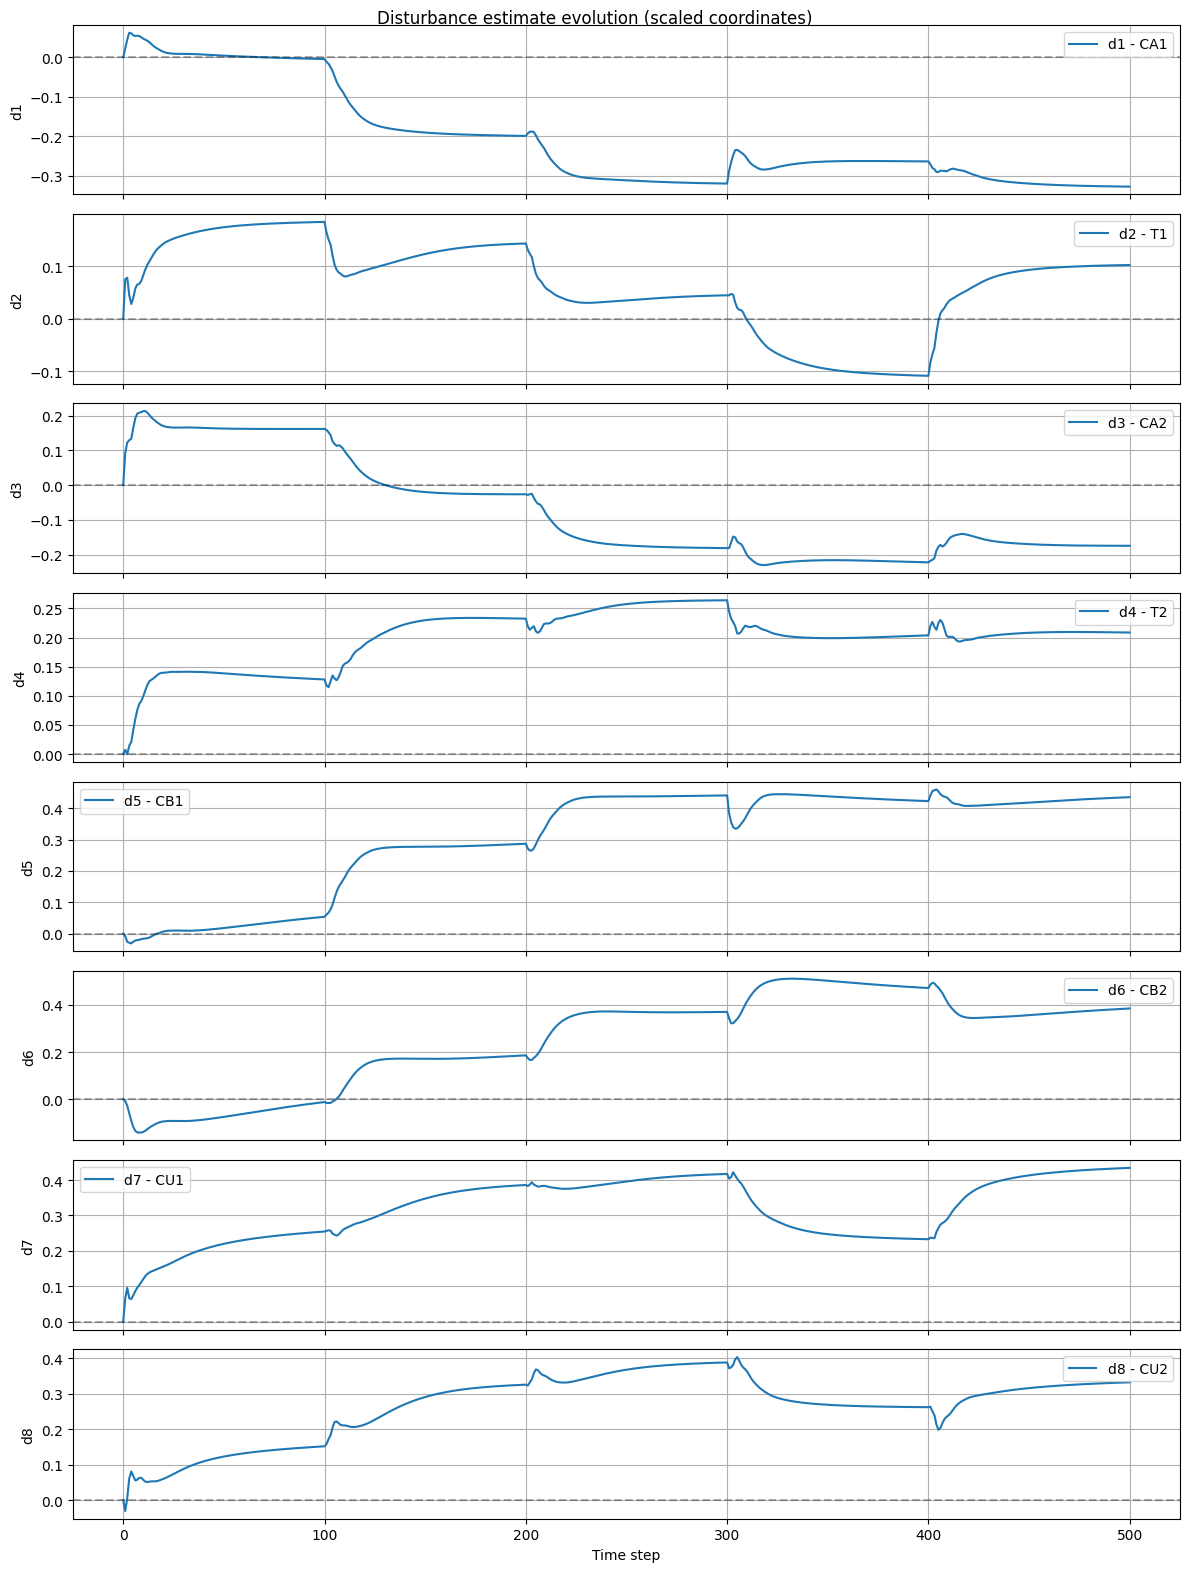

In [45]:
# DIAGNOSTIC: Analyze disturbance evolution
import matplotlib.pyplot as plt
fig_dist, axs_dist = plt.subplots(ny, 1, figsize=(12, 2*ny), sharex=True)
names = ['CA1','T1','CA2','T2','CB1','CB2','CU1','CU2']
for i in range(ny):
    axs_dist[i].plot(z_sim[nz+i, :], label=f'd{i+1} - {names[i]}')
    axs_dist[i].set_ylabel(f'd{i+1}')
    axs_dist[i].grid(True)
    axs_dist[i].legend()
    axs_dist[i].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axs_dist[-1].set_xlabel('Time step')
fig_dist.suptitle('Disturbance estimate evolution (scaled coordinates)')
plt.tight_layout()

print(f"\nDisturbance statistics:")
print(f"Initial disturbance: {z_sim[nz:, 0]}")
print(f"Final disturbance:   {z_sim[nz:, -1]}")
print(f"Mean disturbance:    {np.mean(z_sim[nz:, :], axis=1)}")
print(f"Std disturbance:     {np.std(z_sim[nz:, :], axis=1)}")


Closed-loop objective function value: 23.37390064068797
  - State tracking term: 22.52763989087023
  - Input increment term: 0.8462607498178149


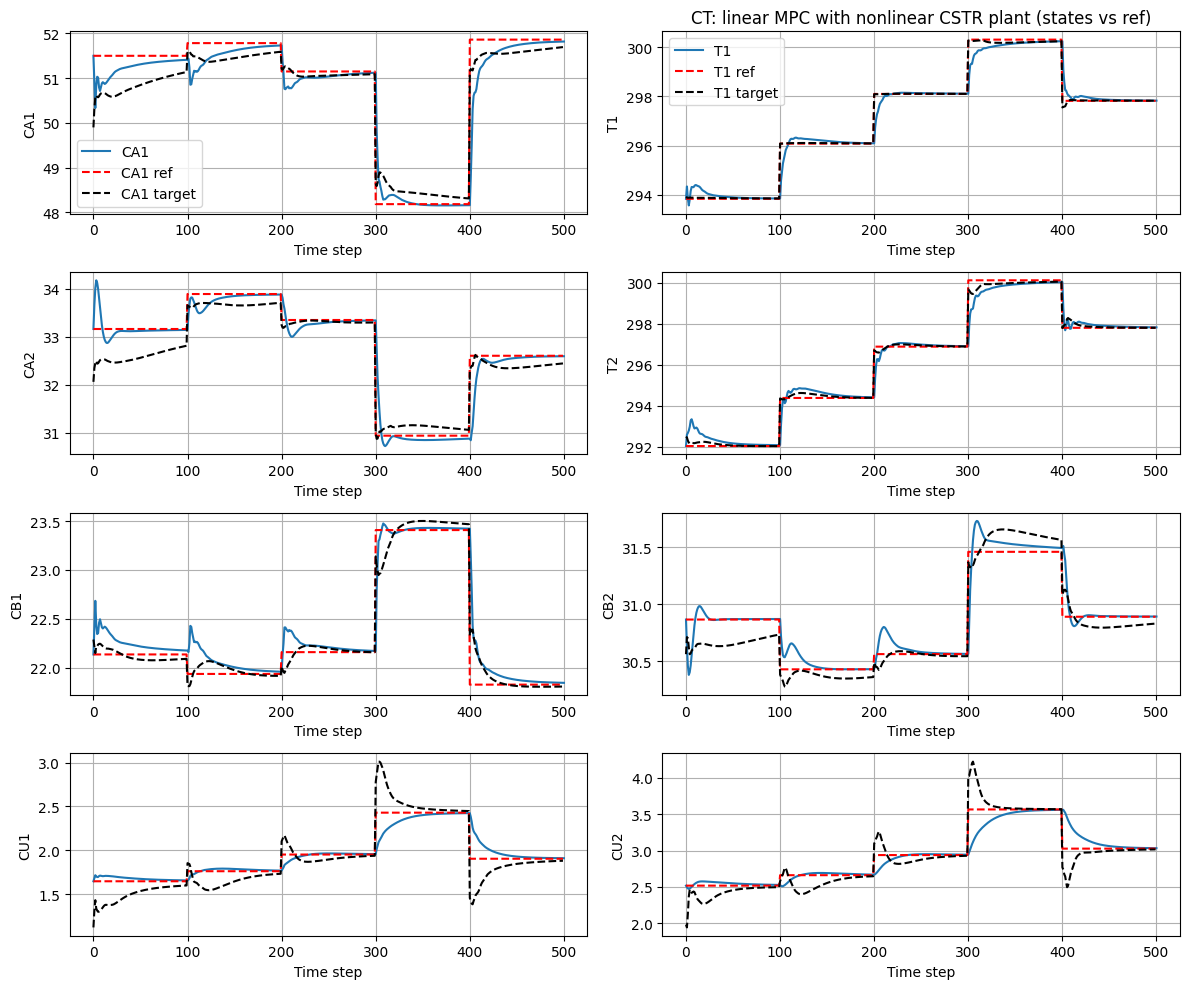

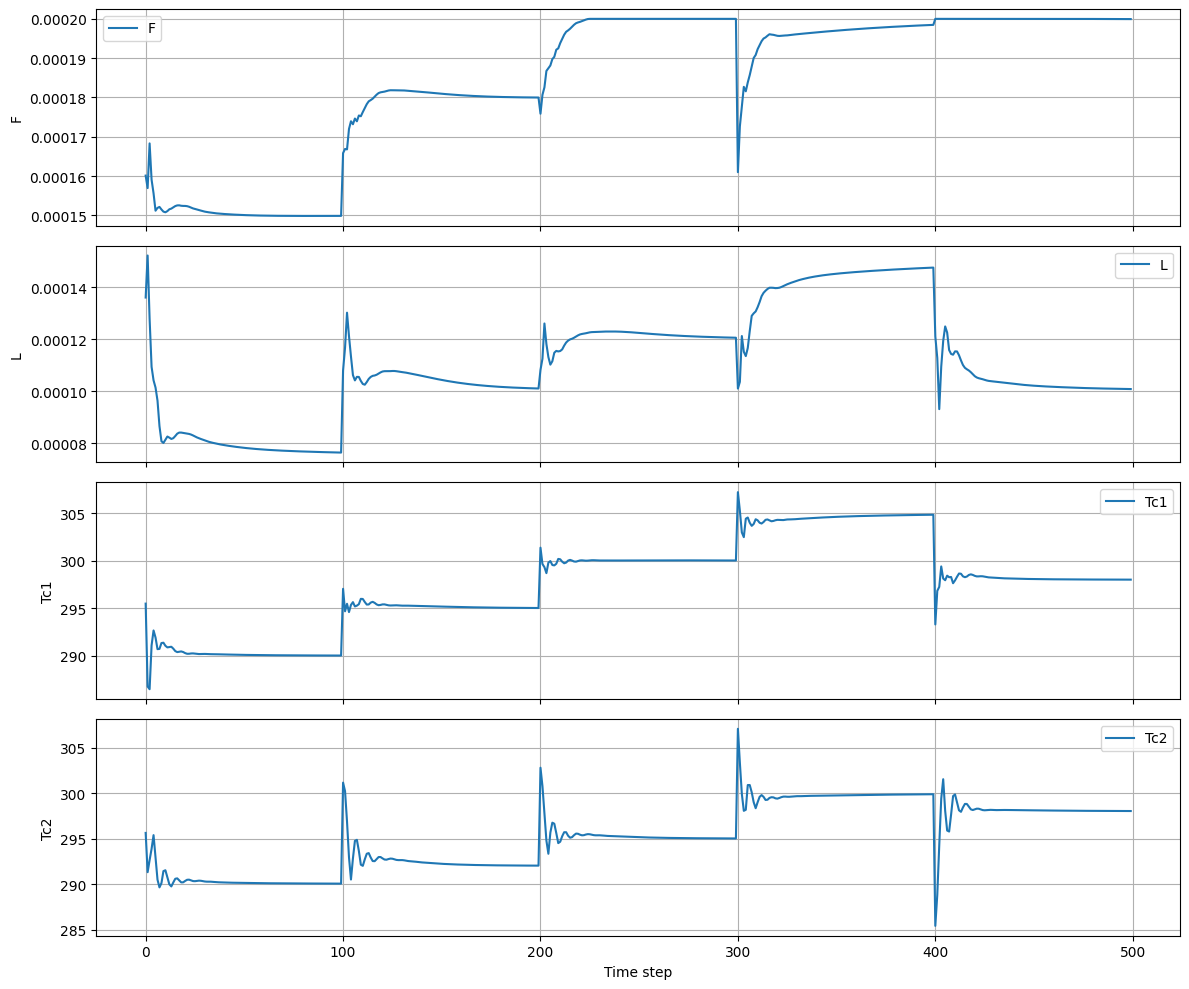

In [49]:
Qu = loaded_setup['Qu']
Qy = loaded_setup['Qy']
objective_value = 0.0
state_error_cost = 0.0
control_increment_cost = 0.0
for k in range(sim_time):
    if reference is not None:
        y_ref_k = reference[:, k]
    else:
        y_ref_k = scaler.inverse_transform(loaded_setup['reference'][:, k].reshape(1, -1))[0]
    y_diff = y_sim[:, k] - y_ref_k
    prev_u = u_sim[:, k - 1] if k > 0 else u_sim[:, k]
    u_diff = u_sim[:, k] - prev_u
    y_term = float(y_diff.T @ Qy @ y_diff)
    u_term = float(u_diff.T @ Qu @ u_diff)
    state_error_cost += y_term
    control_increment_cost += u_term
    objective_value += y_term + u_term

print(f"Closed-loop objective function value: {objective_value}")
print(f"  - State tracking term: {state_error_cost}")
print(f"  - Input increment term: {control_increment_cost}")



# Plots saved to figures/ in non-scaled domain (8 states, 4 inputs)
# Use C_matrix and C_constant for output calculations
ys_sim_ns = scaler.inverse_transform(ys_sim.T).T
zs_sim_ns = scaler.inverse_transform((C_matrix@zs_sim + C_constant.reshape(-1, 1) + z_sim[nz:]).T).T
z_sim_ns = scaler.inverse_transform((C_matrix@z_sim[:nz] + C_constant.reshape(-1, 1) + z_sim[nz:]).T).T
fig = plt.figure(figsize=(12, 10))
names = ['CA1','T1','CA2','T2','CB1','CB2','CU1','CU2']
n_steps = sim_time
for i in range(min(8, ny)):
    plt.subplot(4, 2, i+1)
    plt.plot(y_sim_ns[i, :], label=names[i] if i < len(names) else f'y{i}')
    if reference_ns is not None:
        plt.plot(reference_ns[i, :n_steps+1], 'r--', label=f'{names[i]} ref' if i < len(names) else f'y{i} ref')
    plt.plot(zs_sim_ns[i, :n_steps], 'k--', label=f'{names[i]} target')
    plt.xlabel('Time step')
    plt.ylabel(names[i] if i < len(names) else f'y{i}')
    plt.grid(True)
    if i in (0,1):
        plt.legend()
    if i == 1:
        plt.title('CT: linear MPC with nonlinear CSTR plant (states vs ref)')
plt.tight_layout()
fig.savefig((figures_dir / 'CT_states.png').as_posix(), dpi=200)


fig_inputs, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
input_names = ['F', 'L', 'Tc1', 'Tc2']
for i in range(4):
    axs[i].plot(u_sim_ns[i, :], label=input_names[i])
    axs[i].set_ylabel(input_names[i])
    axs[i].grid(True)
    axs[i].legend()
axs[-1].set_xlabel('Time step')
fig_inputs.tight_layout()


In [47]:
# Use C_matrix and C_constant
C_matrix@z_sim[:nz] + C_constant.reshape(-1, 1) + z_sim[nz:]

array([[ 1.69999392,  1.41775795,  1.37054562, ...,  1.49201158,
         1.49205515,  1.49209775],
       [-2.00536328, -1.14659675, -1.18913886, ..., -0.67293155,
        -0.67295977, -0.67298619],
       [ 2.0604546 ,  1.83597892,  1.89691337, ...,  1.75545736,
         1.75547815,  1.75549841],
       ...,
       [-0.28847402, -1.55741642, -1.61555127, ..., -1.47846816,
        -1.4784637 , -1.47845911],
       [-1.78160381, -1.21231771, -1.19307133, ..., -1.12939837,
        -1.12942064, -1.12944213],
       [-1.90163065, -1.37440916, -1.41179662, ..., -1.26677046,
        -1.26680017, -1.26682837]])

In [48]:
scaler.inverse_transform((C_matrix@z_sim[:nz] + C_constant.reshape(-1, 1) + z_sim[nz:]).T).T

array([[ 5.46866284e+01,  5.07911135e+01,  5.01394731e+01, ...,
         5.18159867e+01,  5.18165881e+01,  5.18171762e+01],
       [ 2.87244745e+02,  2.94064929e+02,  2.93727067e+02, ...,
         2.97826701e+02,  2.97826477e+02,  2.97826267e+02],
       [ 3.52386428e+01,  3.32912438e+01,  3.38198699e+01, ...,
         3.25926933e+01,  3.25928737e+01,  3.25930494e+01],
       ...,
       [ 3.46599531e+01,  3.06413026e+01,  3.04571937e+01, ...,
         3.08913261e+01,  3.08913403e+01,  3.08913548e+01],
       [-9.14990976e-01,  1.54991928e+00,  1.63325277e+00, ...,
         1.90894565e+00,  1.90884926e+00,  1.90875620e+00],
       [ 2.34765435e-01,  2.55761879e+00,  2.39289567e+00, ...,
         3.03185766e+00,  3.03172677e+00,  3.03160252e+00]])

## Analysis: CT vs CT_const comparison

### Key Differences:
1. **CT.ipynb**: Uses `C` matrix (no constant term)
   - Output: `y = C @ z + d`
   - `C` fitted via: `C = argmin ||Y - C @ Z||^2`

2. **CT_const.ipynb**: Uses `C_const = [C_matrix, C_constant]` (with constant term)
   - Output: `y = C_matrix @ z + C_constant + d`
   - `C_const` fitted via: `C_const = argmin ||Y - [C_matrix, C_constant] @ [Z; 1]||^2`

### Important Notes:
- `C_matrix != C` - They are fitted differently!
- `C_const` has better identification (lower residuals) due to extra degrees of freedom
- But control performance depends on how well the constant term generalizes

### Critical Fix Applied:
**Initial Disturbance Initialization**
- OLD: `d_init = 0` (assumed perfect encoder/C_const consistency)
- NEW: `d_init = y_start - (C_matrix @ z_init + C_constant)`
  
This ensures consistency between:
1. The neural network encoder (gives `z_init` from `y_start`)
2. The linear model `C_const` (maps `z` to `y`)
3. The Kalman filter measurement model

Without this fix, the mismatch between encoder and `C_const` causes:
- Large initial disturbance estimates
- Suboptimal control as KF tries to correct the inconsistency
- Systematic bias in state estimation

### Verification Checklist:
✓ Transformation: `C_matrix = C_matrix_orig @ T_real` (C_constant unchanged)
✓ Kalman Filter: Uses `y = [C_matrix, I] @ [z; d] + C_constant`
✓ Target Estimation: Constraint `y_s = C_matrix @ z_s + C_constant + d0`
✓ MPC: Cost on `z` with `Qz = C_matrix.T @ Qy @ C_matrix`
✓ MPC: Constraint `y_k = C_matrix @ z_k + C_constant + d0`
✓ Initial state: `d_init` accounts for encoder/C_const mismatch


## 🔴 ROOT CAUSE IDENTIFIED: C_constant Interferes with Offset-Free MPC

### The Fundamental Problem:

**Offset-free MPC** is designed around a single disturbance estimator `d`:
```
y = C @ z + d    (standard)
```

The Kalman filter estimates `d` to capture **ALL** systematic biases and model mismatches.

**With C_const**, we have:
```
y = C_matrix @ z + C_constant + d    (modified)
```

Now there are **TWO** bias terms:
- `C_constant`: Fixed bias from training data  
- `d`: Estimated bias from Kalman filter

**Result:** The disturbance estimator gets confused! It doesn't know whether to:
1. Keep `d ≈ 0` and trust `C_constant`, OR
2. Adjust `d` to correct for `C_constant`

This causes poor state estimation and suboptimal control!

### Why C_const Has Better Identification But Worse Control:

| Aspect | Training (Identification) | Control (Closed-Loop) |
|--------|--------------------------|----------------------|
| **C without constant** | Higher residuals | Clean disturbance estimation |
| **C_const with constant** | Lower residuals ✓ | Disturbance confusion ✗ |

- During **training**: `C_constant` captures systematic bias → better fit
- During **control**: `C_constant` interferes with `d` → worse performance

### Recommended Solution:

**Set `C_constant = 0` and use only `C_matrix`:**
```python
# Before building KF/TargetEstimation/MPC:
C_constant = np.zeros_like(C_constant)
```

This way:
- Use `C_matrix` (which has better conditioning than `C` due to the augmented fit)
- Let disturbance `d` handle all biases (standard offset-free MPC framework)
- Avoid double-counting bias terms


## Summary of Fix and Expected Results

### What Changed:

**Cell 7:** Added code to zero out `C_constant` before building KF/TargetEstimation/MPC
```python
C_constant = np.zeros_like(C_constant)  # OPTION 1 (recommended)
```

### Why This Works:

1. **Still uses `C_matrix`** (not the original `C`)
   - `C_matrix` comes from fitting `[C_matrix, C_constant]` via augmented least squares
   - Has better conditioning than original `C` due to extra degrees of freedom
   
2. **Avoids bias double-counting**
   - Sets `C_constant = 0` so only disturbance `d` captures biases
   - Follows standard offset-free MPC framework
   
3. **Maintains all other improvements**
   - Still uses transformed matrices via `T_real`
   - Still uses proper KF/TE/MPC formulations

### Expected Performance:

With `C_constant = 0`:
- **Better than or equal to CT.ipynb** (which had objective ~22.42)
- Benefits from improved `C_matrix` fitting
- Clean disturbance estimation without interference
- Should see `d` behaving reasonably in disturbance plots

### To Test the Original (Broken) Version:

Change OPTION 1 to OPTION 2 in Cell 7:
```python
# C_constant_fixed = np.zeros_like(C_constant)  # Comment this
C_constant_fixed = C_constant.copy()  # Uncomment this
```

You should see worse performance (~23.37 or higher) due to disturbance confusion.
